In [1]:
# Loading packages
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import statsmodels
from scipy import stats

In [2]:
start = '2018-04-01' # start date of time series
today = '2021-04-01' # end date of time series

# SWI20 (yahoo) tickers
swi = ['SGSN.SW','SCMN.SW','GIVN.SW','ZURN.SW','NOVN.SW',
          'ROG.SW','CSGN.SW','LHN.SW','ABBN.SW','UHR.SW',
          'LONN.SW','SLHN.SW','PGHN.SW','GEBN.SW','NESN.SW',
          'SREN.SW','CFR.SW','UBSG.SW','SIKA.SW','ALC.SW']

# Names of those SWI firms
swi_names = ['SGS','Swisscom','Givaudan','Zurich Insurance Group','Novartis',
         'Roche','Credit Suisse','LafargeHolcim','ABB','Swatch Group',
         'Lonza','Swiss Life Holding','Partners Group','Geberit','Nestle',
         'Swiss Re','Richemont','UBS','Sika','Alcon']

# more_ticks = ['ADEN.SW','BAER.SW','CLN.SW','GIVN.SW','KNIN.SW','SOON.SW']
# more_names = ['Adecco Group','Julius Bär','Clariant','Givaudan','Kuehne + Nagel International','Sonova']

In [3]:
# Fetch daily price and volume data from yahoo; calculate log prices
def get_data(ticks,start_date,end_date):    
    prices = []
    for i in ticks:
        closing = pdr.DataReader(i,
                                 data_source='yahoo',
                                 start=start_date,
                                 end=end_date
                                ).iloc[:,-1]
        prices.append(closing)

    prices = pd.concat(prices,axis=1)
    prices.columns = ticks
    prices_logs = np.log(prices/prices.shift(1))

    volumes = []
    for i in ticks:
        vol = pdr.DataReader(i,
                                 data_source='yahoo',
                                 start=start_date,
                                 end=end_date
                                ).iloc[:,-2]
        volumes.append(vol)

    volumes = pd.concat(volumes,axis=1)
    volumes.columns = ticks
    
    return prices, prices_logs, volumes

# Calculate ADTV and sort them by value - last month
def ADTV(volumes):
    adtv = pd.DataFrame(data=[volumes.iloc[-20:,:].mean(),
                              volumes.iloc[-250*3:,:].mean()],
                        index=['Last month','Last three years']) \
                        .transpose()
    adtv_sorted = adtv.sort_values(by='Last month',ascending=False)
    return adtv_sorted

# Plot prices or volumes
def plot_volumes(prices):
    tcks = prices.columns
    fig, ax = plt.subplots(nrows=len(tcks),ncols=1,
                           figsize=[16,9*2],dpi=100)
    for i in range(len(tcks)):
        ax[i].plot(prices.iloc[:,i])
        ax[i].set_title(tcks[i])
    plt.tight_layout()
    
# Plot log prices
def plot_volatility(logprices):
    tcks = logprices.columns
    fig, ax = plt.subplots(nrows=len(tcks),ncols=1,
                           figsize=[16,9*2],dpi=100)
    for i in range(len(tcks)):
        ax[i].plot(logprices.iloc[:,i])
        ax[i].axhline(y=0,c='k')
        ax[i].set_title(tcks[i])
    plt.tight_layout()
    
# Lending Value (not adjusted)
def LV(log_prices,alpha,epsilon,delta):
    mu = log_prices.mean()
    sigma = log_prices.std()
    drift = (mu-sigma**2/2)*delta
    diffusion = sigma**2*delta
    lv = ( (1-alpha)*(np.exp(drift+sigma*np.sqrt(delta)*stats.norm.ppf(epsilon))) ) / \
    ( 1-alpha*(np.exp(drift+sigma*np.sqrt(delta)*stats.norm.ppf(epsilon))) )
    return lv

# Lending Value adjusted for liquidity
def LV_adj(log_prices,alpha,epsilon,delta):
    mu = log_prices.mean()
    sigma = log_prices.std()
    drift = (mu-sigma**2/2)*delta
    diffusion = sigma**2*delta
    x = 0
    gamma = 0
    lv_adj = 0
    return lv_adj

In [4]:
# SWI stocks prices for the last 3 years
prices_swi = get_data(swi,start,today)[0]
# Same but log prices
logprices_swi = get_data(swi,start,today)[1]
# Same but volume
volumes_swi = get_data(swi,start,today)[2]

In [5]:
prices_swi

,SGSN.SW,SCMN.SW,GIVN.SW,ZURN.SW,NOVN.SW,ROG.SW,CSGN.SW,LHN.SW,ABBN.SW,UHR.SW,LONN.SW,SLHN.SW,PGHN.SW,GEBN.SW,NESN.SW,SREN.SW,CFR.SW,UBSG.SW,SIKA.SW,ALC.SW
Date,,,,,,,,,,,,,,,,,,,,
2018-04-03,2109.201904,405.845978,2032.542114,258.951904,60.724930,196.694016,14.082186,43.794113,18.626474,388.202332,215.105362,287.630096,643.263855,386.598572,68.466255,80.018456,79.870483,12.491334,118.438713,NaN
2018-04-04,2100.118652,406.283020,2008.121704,258.617859,60.756592,195.372406,13.810002,43.455940,18.279289,387.647339,214.131165,283.900177,635.052063,383.457001,68.300575,76.930611,79.682999,12.249225,116.283829,NaN
2018-04-05,2148.261230,413.800293,2065.416260,259.703430,62.181320,199.200546,14.189275,44.910107,18.930262,398.746796,223.288712,286.951965,643.720093,392.050140,69.607674,78.026299,80.901688,12.619954,119.316635,NaN
2018-04-06,2141.902832,413.433624,2075.747803,264.223877,61.484787,197.970062,13.984022,44.690292,18.669872,397.544312,221.924820,288.647400,639.614136,391.576538,69.939056,78.109291,80.489212,12.498900,117.640610,NaN
2018-04-09,2148.261230,413.250275,2075.747803,263.692047,61.405628,198.289078,14.010795,44.555016,18.869505,399.394226,221.437729,289.071259,642.807617,391.765991,69.957466,78.955963,81.651634,12.544294,117.321365,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,2666.000000,505.200012,3567.000000,402.100006,81.879997,303.649994,12.470000,55.020000,28.490002,268.200012,548.599976,465.399994,1220.500000,594.599976,104.139999,93.720001,89.739998,15.125000,265.500000,65.239998
2021-03-29,2704.000000,508.200012,3611.000000,405.399994,82.379997,304.500000,10.745000,55.119999,28.440001,269.200012,544.200012,465.899994,1200.000000,600.000000,105.220001,94.239998,90.379997,14.535000,266.100006,65.059998
2021-03-30,2720.000000,507.600006,3618.000000,410.100006,81.860001,303.850006,10.415000,56.060001,28.520000,278.000000,528.599976,470.200012,1220.500000,605.000000,105.940002,94.559998,92.580002,14.690000,268.600006,66.599998


In [6]:
ADTV(volumes_swi)

,Last month,Last three years
CSGN.SW,73151777.45,1.400465e+07
ABBN.SW,61414701.75,9.132641e+06
SGSN.SW,58037893.90,1.572488e+06
UHR.SW,56812543.80,1.792947e+06
ALC.SW,56747076.25,4.068682e+06
UBSG.SW,14348981.15,1.669469e+07
NOVN.SW,5800719.20,5.847903e+06
NESN.SW,4866203.80,5.770842e+06
LHN.SW,1962888.75,2.583970e+06
ROG.SW,1727275.40,1.847381e+06


In [86]:
# Select the most liquid, 5th liquid, 10th liquid, 16th liquid and the least liquid stock in the SMI index
selection = [0,4,9,15,19]
ADTV(volumes_swi).iloc[selection,:]

selected_ticks = list(ADTV(volumes_swi).iloc[selection,:].index)
selected_prices = prices_swi[selected_ticks]
selected_logprices = logprices_swi[selected_ticks]
selected_volumes = volumes_swi[selected_ticks]

### Descriptive stats for price time series of selected stocks

In [87]:
selected_prices.describe()
# only 2 years of data for ALC.SW

,CSGN.SW,ALC.SW,ROG.SW,SLHN.SW,GIVN.SW
count,752.000000,498.000000,752.000000,752.000000,752.000000
mean,11.391024,57.359942,268.380182,381.856582,2832.275147
std,1.813768,4.362062,41.038336,60.985575,591.298827
min,6.200624,38.714115,189.311157,246.679886,2008.121704
25%,10.233524,55.210001,231.660065,326.705338,2273.930176
50%,11.369372,57.754824,268.433411,370.949997,2683.684692
75%,12.414352,59.569906,304.035645,442.747879,3427.748474
max,15.771125,68.480003,343.690338,492.792725,4003.174072


### Plots: price, volatility and volume time series

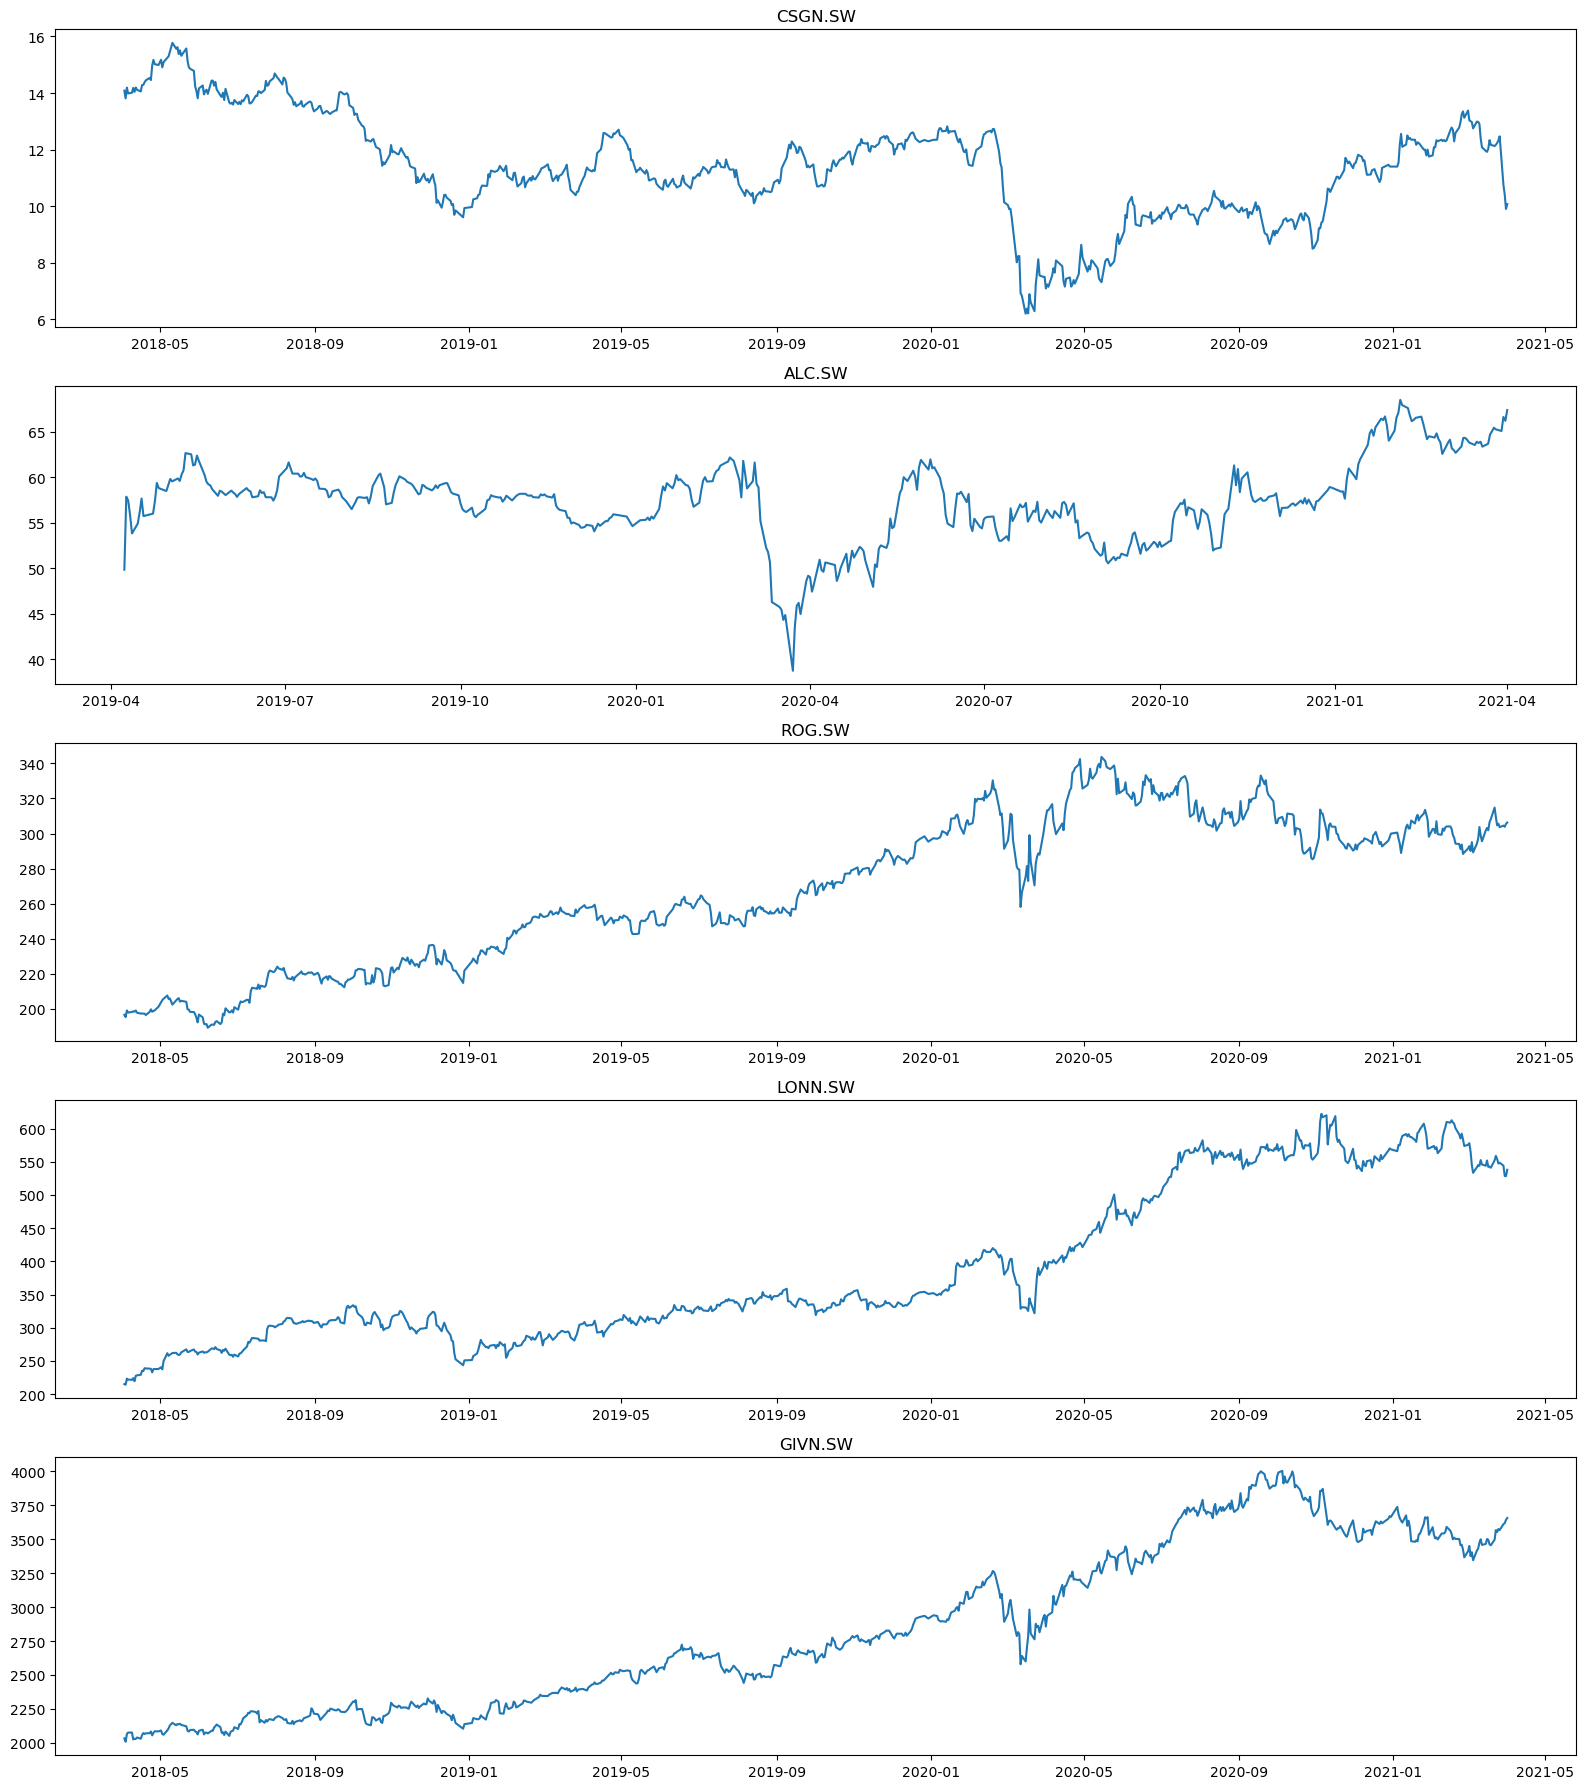

In [9]:
# Stock price time series
plot_volumes(selected_prices)

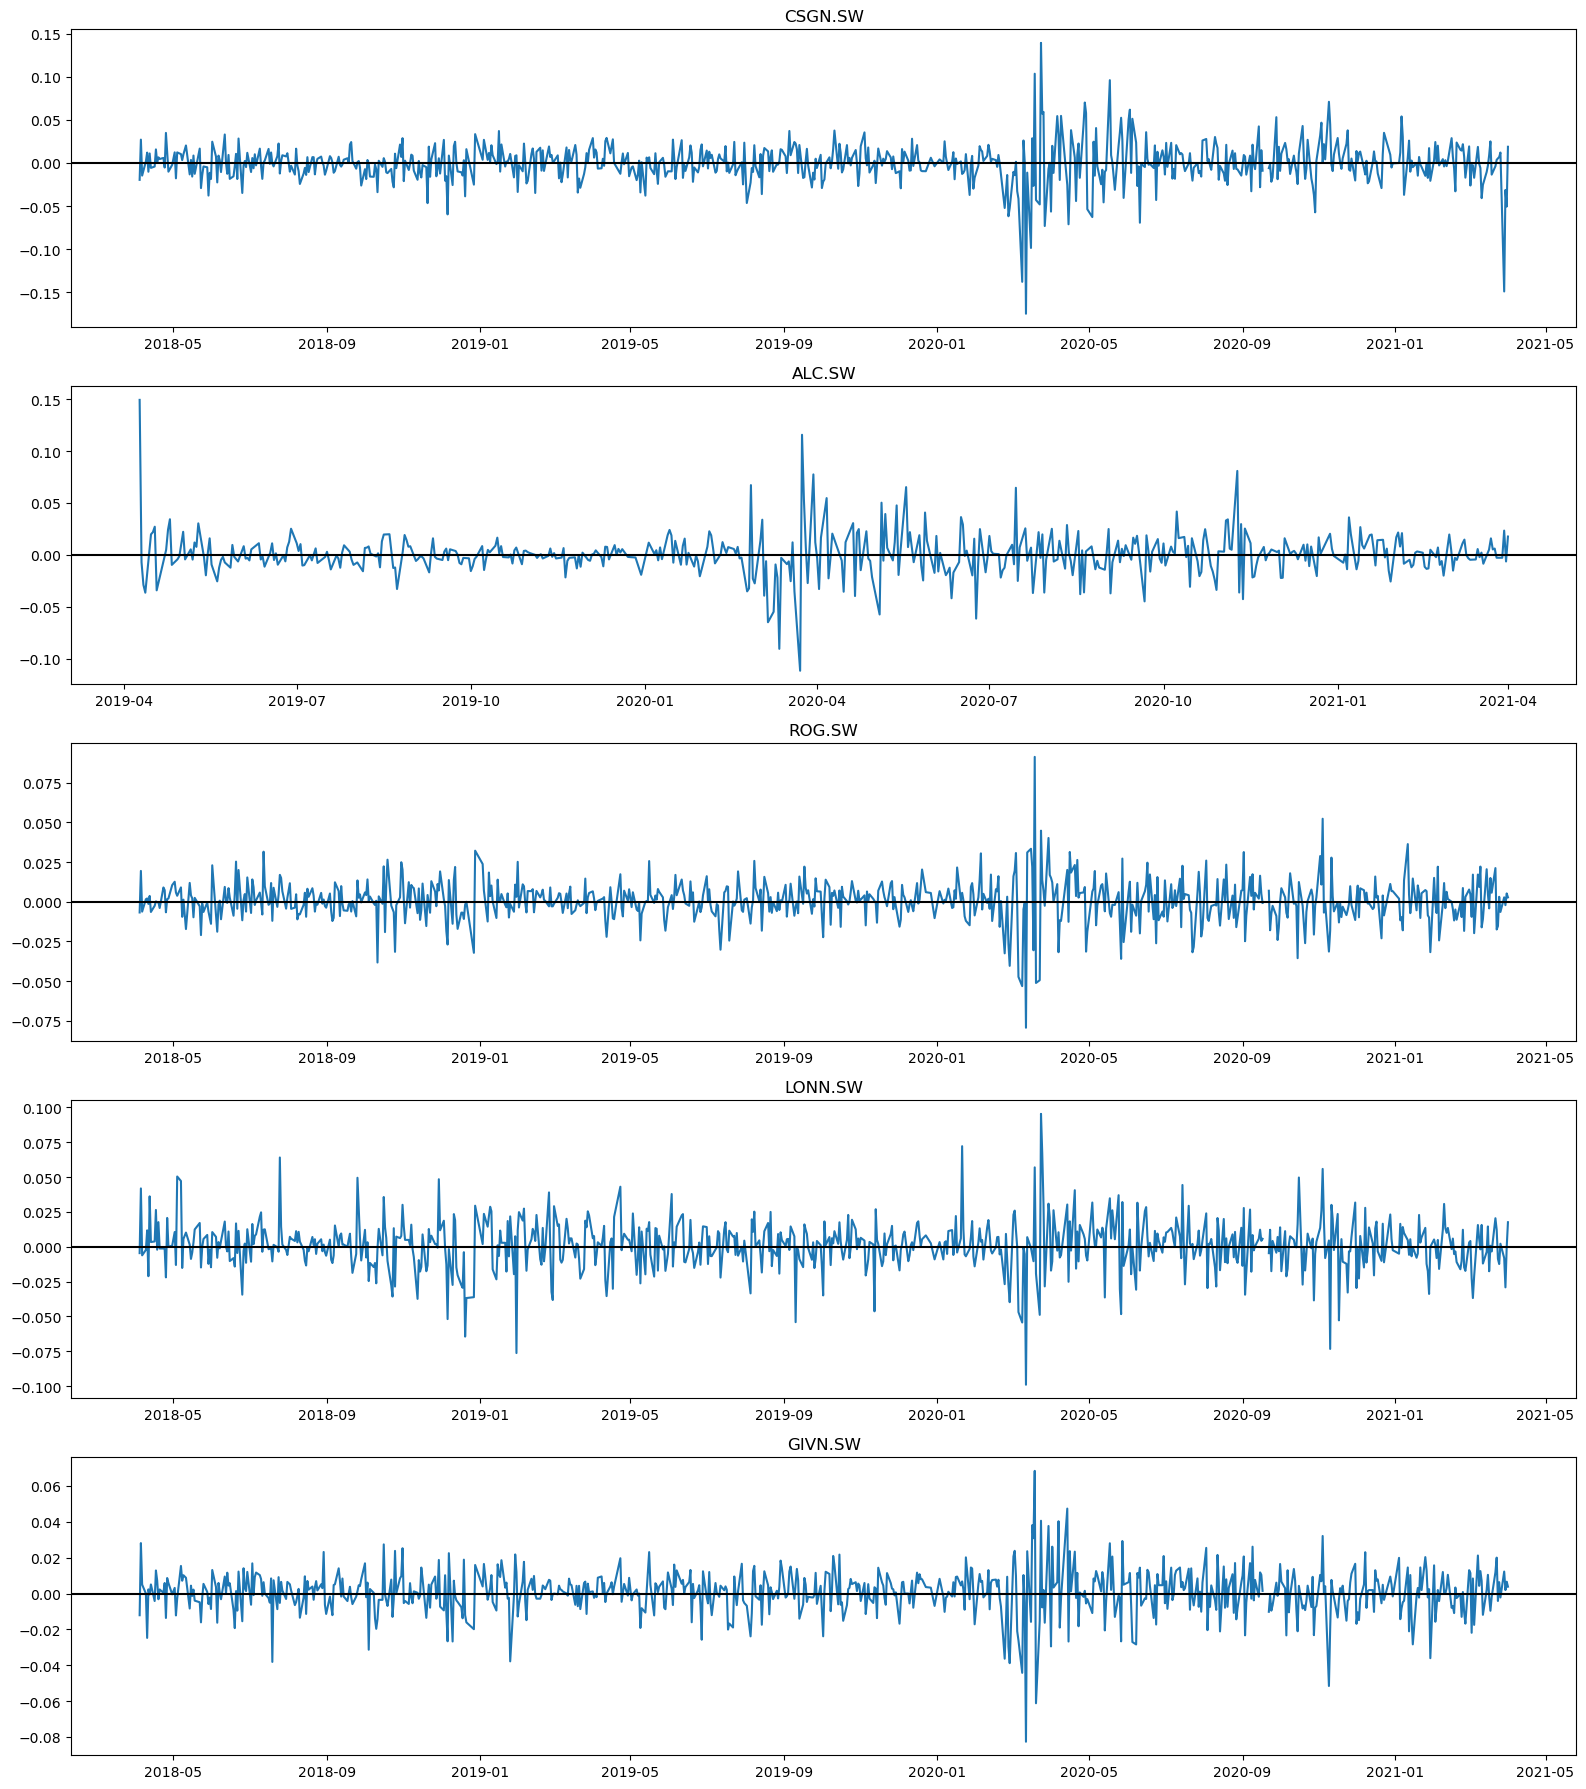

In [10]:
# Stock volatility time series
plot_volatility(selected_logprices)

In [63]:
selected_volumes

,CSGN.SW,ALC.SW,ROG.SW,LONN.SW,GIVN.SW
Date,,,,,
2018-04-03,1.178687e+07,NaN,1556943.0,415563.0,40240.0
2018-04-04,1.476681e+07,NaN,2216032.0,420495.0,32091.0
2018-04-05,1.241693e+07,NaN,1899827.0,534597.0,44827.0
2018-04-06,9.863533e+06,NaN,1253141.0,274734.0,33626.0
2018-04-09,8.346454e+06,NaN,1074337.0,256341.0,31586.0
...,...,...,...,...,...
2021-03-26,8.222699e+06,1.018582e+06,1770537.0,130630.0,30052.0
2021-03-29,7.398620e+07,8.596930e+05,1229095.0,182202.0,25252.0
2021-03-30,4.519656e+07,9.863660e+05,1308476.0,269795.0,14372.0


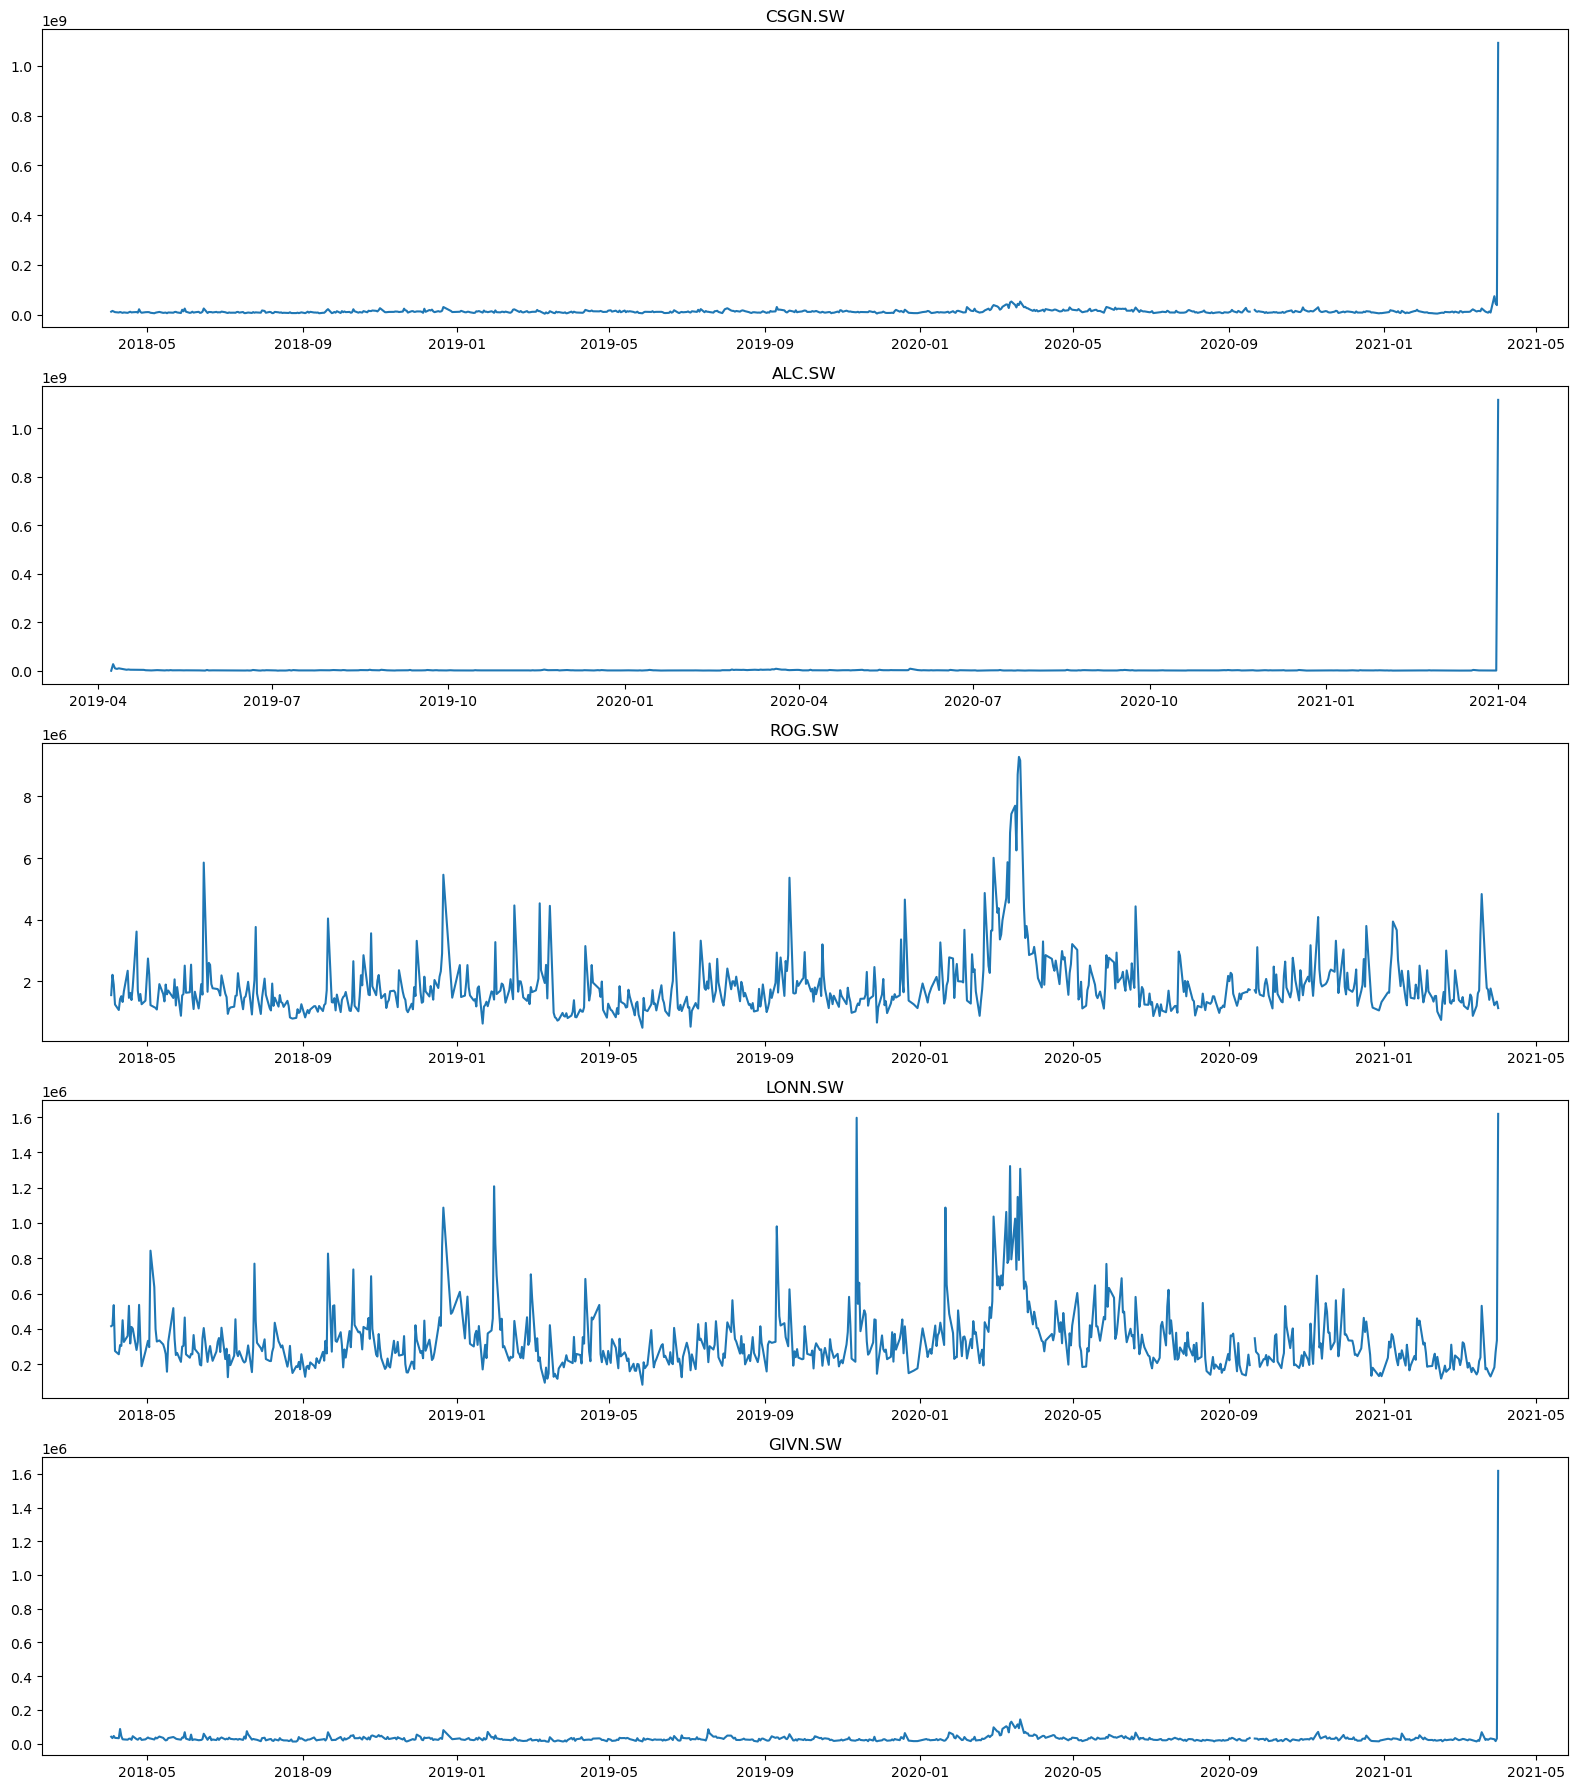

In [62]:
# Stock trading volume time series
plot_volumes(selected_volumes)

## Model

In [12]:
# Parameters
alpha = 0.25
epsilon = 0.01
delta = 10

### SMI

In [73]:
smi_lvs = []
for i in range(len(logprices_swi.columns)):
    lv = LV(logprices_swi.iloc[:,i],alpha,epsilon,delta)
    smi_lvs.append(lv)
smi_lvs = pd.DataFrame(lvs,index=swi)
smi_lvs.columns = ['Lending Value']

smi_lvs

,Lending Value
SGSN.SW,0.885708
SCMN.SW,0.897762
GIVN.SW,0.894972
ZURN.SW,0.866619
NOVN.SW,0.886940
ROG.SW,0.886076
CSGN.SW,0.795550
LHN.SW,0.846945
ABBN.SW,0.857911
UHR.SW,0.826452


In [85]:
# LV for selected stocks
smi_lvs.loc[selected_ticks,:].sort_values(by='Lending Value',ascending=False)

,Lending Value
GIVN.SW,0.894972
ROG.SW,0.886076
LONN.SW,0.852888
ALC.SW,0.824434
CSGN.SW,0.795550


### Tesla

In [75]:
tsla_logs = get_data(['TSLA'],start,today)[1]

tsla_lv = LV(tsla_logs,alpha,epsilon,delta)
print('Lending Value for Tesla stock collateral: '+str(tsla_lv[0].round(2)))

Lending Value for Tesla stock collateral: 0.68


---
---
## Hubert's todo

- Adjust the model for liquidity
- Model the lombard process
- CAPM
- VaR and ES
- Backtesting
- Other papers